Intentar hacer que pueda rotar y todo con el cuadrado dibujado

In [7]:
import numpy as np
import cv2 as cv

# Cargar la imagen original
img = cv.imread('material_pract5/manzana.png', cv.IMREAD_COLOR)
h, w = img.shape[:2]

# Variables globales para transformaciones
tx, ty = 0, 0
angle = 0
scale_x = 1.0
scale_y = 1.0

def update_image():
    global tx, ty, angle, scale_x, scale_y

    # Centro de la imagen para la rotación
    center = (w / 2, h / 2)

    # Crear la matriz de transformación afín
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    M[0, 0] *= scale_x
    M[0, 1] *= scale_x
    M[1, 0] *= scale_y
    M[1, 1] *= scale_y
    M[0, 2] += tx
    M[1, 2] += ty

    # Aplicar la transformación afín sobre la imagen original
    transformed_image = cv.warpAffine(img, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0))
    cv.imshow('image', transformed_image)

def on_trackbar_rotation(val):
    global angle
    angle = val
    update_image()

def on_trackbar_translation(val):
    global tx, ty
    tx = val - 100  # Permitir traslación negativa
    ty = val - 100  # Permitir traslación negativa
    update_image()

def on_trackbar_resize(val):
    global scale_x, scale_y
    scale_x = val / 100
    scale_y = val / 100
    update_image()

def on_trackbar_resize_x(val):
    global scale_x
    scale_x = val / 100
    update_image()

def on_trackbar_resize_y(val):
    global scale_y
    scale_y = val / 100
    update_image()


drawing = False  # Verdadero si el ratón está presionado
mode = 0  # 0: rectángulo, 1: círculo
ix, iy = -1, -1

# Función de callback para el ratón
def draw_figures(event, x, y, flags, param):
    global ix, iy, drawing, mode, points

    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = img.copy()  # Copia de la imagen para dibujar en tiempo real
            thickness = 1  # Grosor fijo para el dibujo
            color = (0, 0, 255)  # Color blanco
            cv.rectangle(img_copy, (ix, iy), (x, y), color, thickness)        
            cv.imshow('image', img_copy)


    elif event == cv.EVENT_LBUTTONUP:
        if not drawing:
            return
        drawing = False
        thickness = 1  # Grosor fijo
        color = (0, 0, 255)  # Color rojo
        cv.rectangle(img, (ix, iy), (x, y), color, thickness)
        cv.imshow('image', img)
    
# Configuración inicial
cv.namedWindow('image')
cv.setMouseCallback('image', draw_figures)
cv.createTrackbar('Rotation', 'image', 0, 360, on_trackbar_rotation)
cv.createTrackbar('Translation', 'image', 100, 200, on_trackbar_translation)  # Centrar en 0
cv.createTrackbar('Resize', 'image', 100, 200, on_trackbar_resize)
cv.createTrackbar('Resize X', 'image', 100, 200, on_trackbar_resize_x)
cv.createTrackbar('Resize Y', 'image', 100, 200, on_trackbar_resize_y)

while True:
    update_image()
    # Mostrar la imagen con los controles
    img_copy = img.copy()
    cv.imshow('image', img_copy)

    k = cv.waitKey(1) & 0xFF
    if k == ord('n'):  # Limpiar la imagen
        img = cv.imread('material_pract5/manzana.png', cv.IMREAD_COLOR)
    elif k == 27:  # Tecla 'ESC' para salir
        break
    
update_image()
cv.destroyAllWindows()


Solo dibuja el rectangulo y la comparacion se realizaria con otra imagen previamnete rotada



1. Al hacer clic y mantener presionado el ratón, se inicia el dibujo del rectángulo.
Durante el movimiento del ratón, el código crea una copia temporal img_copy de img, dibuja el rectángulo sobre img_copy, y luego muestra img_copy en la ventana.
Esto da la ilusión de un rectángulo en tiempo real, pero img en sí no se modifica.
Finalización del Dibujo:

2. Al soltar el clic, drawing se establece en False, se capturan las coordenadas finales, y img se vuelve a mostrar sin el rectángulo temporal.
Inmediatamente después, crop_image() se llama para realizar el recorte.
Recorte de la Imagen:

3. crop_image() recorta directamente img en la región delimitada por las coordenadas (ix, iy) y (fx, fy).
Luego, muestra la imagen recortada en una nueva ventana "Imagen Recortada".

Total matches: 48


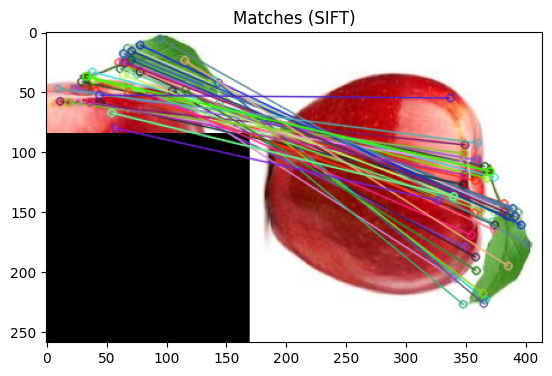

In [3]:
import cv2 as cv
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

# Variables globales
drawing = False  # Verdadero si el ratón está presionado
ix, iy = -1, -1  # Coordenadas iniciales del ratón
fx, fy = -1, -1  # Coordenadas finales del ratón
img = None  
cropped_image = None  # Imagen recortada para los matches

# Función de callback para el ratón
def draw_figures(event, x, y, flags, param):
    global ix, iy, fx, fy, drawing, img

    if event == cv.EVENT_LBUTTONDOWN:  # Al hacer clic, inicia el dibujo
        drawing = True
        ix, iy = x, y

    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            # Dibuja un rectángulo en tiempo real sobre una copia temporal
            img_copy = img.copy()
            cv.rectangle(img_copy, (ix, iy), (x, y), (0, 0, 255), 1)
            cv.imshow('Imagen', img_copy)

    elif event == cv.EVENT_LBUTTONUP:  # Al soltar el clic, fija el dibujo
        drawing = False
        fx, fy = x, y
        cv.imshow('Imagen', img)  
        crop_image()  # Llama a la función para recortar la imagen


def crop_image():
    global img, ix, iy, fx, fy, cropped_image
    x1, y1 = min(ix, fx), min(iy, fy)
    x2, y2 = max(ix, fx), max(iy, fy)
    cropped_image = img[y1:y2, x1:x2]  # Recorta la imagen original
    cv.imshow('Imagen Recortada', cropped_image)  
    open_second_file()  # Llama a la función para abrir la segunda imagen y encontrar los matches


# Método para encontrar los matches con SIFT entre la imagen recortada y una segunda imagen
def sift_matches(img2):
    global cropped_image
    # Convertir la imagen recortada a escala de grises
    img1_gray = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # Crear el objeto SIFT
    sift = cv.SIFT_create()

    # Detectar puntos clave y calcular descriptores
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # Usar BFMatcher para encontrar los mejores matches
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Ordenar los matches por distancia
    matches = sorted(matches, key=lambda x: x.distance)
    print(f"Total matches: {len(matches)}")

    # Dibujar los primeros 50 matches
    img_matches = cv.drawMatches(cropped_image, keypoints1, img2, keypoints2, matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Mostrar la imagen con los matches
    cv.imshow('Matches (SIFT)', img_matches)
    cv.waitKey(0)
    cv.destroyAllWindows()

    # Mostrar usando matplotlib
    plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
    plt.title('Matches (SIFT)')
    plt.show()

# Función para abrir la primera imagen y mostrarla en OpenCV
def open_file():
    global img
    # Abrir cuadro de diálogo para seleccionar archivo
    file_path = filedialog.askopenfilename(filetypes=[("PNG Files", "*.png"), ("JPG Files", "*.jpg")])
    if file_path:
        # Cargar la imagen con PIL y convertirla para OpenCV
        img = Image.open(file_path).convert("RGB")  
        img = np.array(img)  
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)  
        cv.imshow('Imagen', img)
        
        cv.setMouseCallback('Imagen', draw_figures)
        
        cv.waitKey(0)
        cv.destroyAllWindows()

# Función para abrir la segunda imagen
def open_second_file():
    # Abrir cuadro de diálogo para seleccionar la segunda imagen
    file_path = filedialog.askopenfilename(filetypes=[("PNG Files", "*.png"), ("JPG Files", "*.jpg")])
    if file_path:
        # Cargar la segunda imagen con PIL y convertirla para OpenCV
        img2 = Image.open(file_path).convert("RGB")
        img2 = np.array(img2)
        img2 = cv.cvtColor(img2, cv.COLOR_RGB2BGR)
        
        # Llama a la función para encontrar los matches con la segunda imagen
        sift_matches(img2)

# Configuración de la ventana de Tkinter
window = tk.Tk()
window.title("Interfaz de Selección de Imagen")
window.geometry("500x500")

# Botón para seleccionar la primera imagen
open_button = tk.Button(window, text="Abrir primera imagen", command=open_file)
open_button.pack(pady=20)

# Ejecuta la ventana de Tkinter
window.mainloop()
